In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%pylab inline
import os
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator, array_to_img

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
# deal with truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Populating the interactive namespace from numpy and matplotlib


# Data Prep
- From the initial training images, put 1,000 images into the train directory and 400 into the validation directory

# EDA

In [7]:
number_of_classes = 3

In [8]:
rootdir = '../kaggle - Cervical Cancer Screening/data/train'
train_images_pd = pd.DataFrame()
all_train_images = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        full_path = os.path.join(subdir, file)
        all_train_images.append(full_path)
train_images_pd['image_path']=all_train_images
train_images_pd['type'] = [ x.split('/')[-2] for x in all_train_images] 
all_train_images.remove('../kaggle - Cervical Cancer Screening/data/train/.DS_Store')

In [9]:
train_images_pd .head()

,image_path,type
0,../kaggle - Cervical Cancer Screening/data/tra...,train
1,../kaggle - Cervical Cancer Screening/data/tra...,type_1
2,../kaggle - Cervical Cancer Screening/data/tra...,type_1
3,../kaggle - Cervical Cancer Screening/data/tra...,type_1
4,../kaggle - Cervical Cancer Screening/data/tra...,type_1


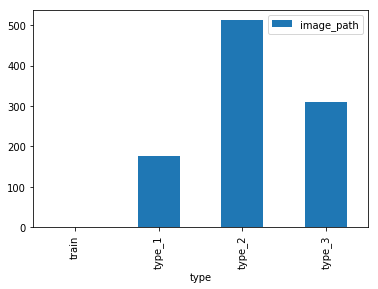

In [40]:
train_images_pd.groupby('type').count().plot(kind='bar')

In [41]:
print('Total of {} images'.format(train_images_pd.shape[0]))

Total of 1001 images


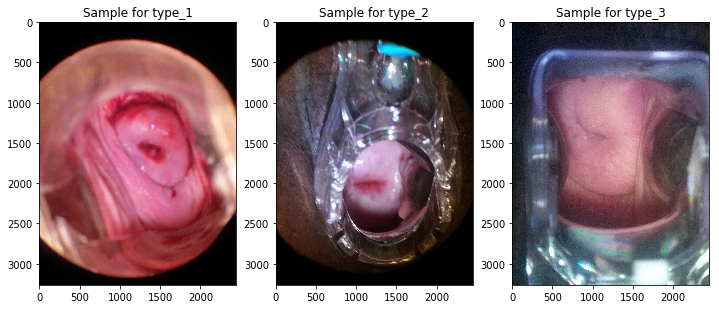

In [64]:
i = 1
fig = plt.figure(figsize=(12,8))
for t in ['type_1','type_2','type_3']:
    ax = fig.add_subplot(1,3,i)
    plt.title('Sample for {}'.format(t))
    i+=1
    f = train_images_pd[train_images_pd.type == t].iloc[0,:]['image_path']
    plt.imshow(plt.imread(f))

# Next, look at image dimensions

In [95]:
[plt.imread(train_images_pd[train_images_pd.type=='type_1'].iloc[i,:]['image_path']).shape for i in range(1,15,2)]

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

[(4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3)]

In [94]:
[plt.imread(train_images_pd[train_images_pd.type=='type_2'].iloc[i,:]['image_path']).shape for i in range(1,15,2)]

[(3264, 2448, 3),
 (3264, 2448, 3),
 (4128, 3096, 3),
 (4128, 2322, 3),
 (4128, 3096, 3),
 (3264, 2448, 3),
 (4128, 3096, 3)]

In [96]:
[plt.imread(train_images_pd[train_images_pd.type=='type_3'].iloc[i,:]['image_path']).shape for i in range(1,15,2)]

[(4128, 3096, 3),
 (4128, 3096, 3),
 (3264, 2448, 3),
 (4128, 3096, 3),
 (3264, 2448, 3),
 (3264, 2448, 3),
 (3264, 2448, 3)]

# Set up data generator

In [41]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    from keras.applications.vgg16 import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [42]:
train_datagen = ImageDataGenerator(
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory='data/train',
                                                    target_size=[224, 224],
                                                    batch_size=16,
                                                   classes=['type_1','type_2','type_3'])

Found 1000 images belonging to 3 classes.


In [43]:
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(directory='data/validation/',
                                                              target_size=[224, 224],
                                                              batch_size=16,
                                                             classes=['type_1','type_2','type_3'])

Found 481 images belonging to 3 classes.


### Examine some images after the data augmentation

In [44]:
x_train_augment, y_train_augment = next(train_generator)

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

# Test VGG16 for transfer learning
- First, test out of the box predictions

In [45]:
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Replace the last layer with only three classes

In [46]:
fc2 = vgg16.get_layer('fc2').output
p = Dense(output_dim=3, activation='softmax', name='logit')(fc2)
model = Model(input=vgg16.input, output=p)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", name="logit", units=3)`
  
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("lo...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
X_val_sample, y_actual = next(validation_generator)
y_pred = model.predict(X_val_sample)






In [142]:
y_actual[:]

array([[ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]], dtype=float32)

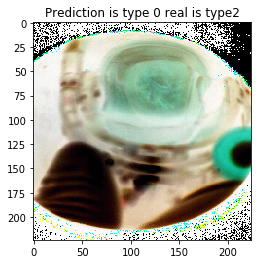

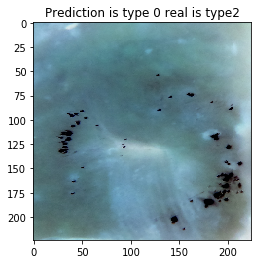

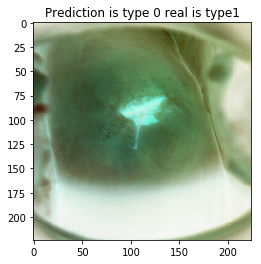

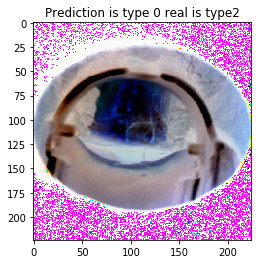

In [147]:
nb_sample = 4
for x, y,z in zip(X_val_sample[:nb_sample], y_pred[:nb_sample],y_actual[:nb_sample,:]):
    plt.figure()
    plt.imshow(x)

    plt.title('Prediction is type {} real is type{}'.format(np.argmax(y),np.argmax(z)))

# Test training just the bottleneck features

In [47]:
model_bottleneck = model

In [48]:
model_bottleneck.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

In [49]:
for k,v in model_bottleneck.layers_by_depth.items():
    print(k,v[0].trainable,v)
    if k < 3:
        pass
    else:
        v[0].trainable = False

0 True [<keras.layers.core.Dense object at 0x126a7aba8>]
1 True [<keras.layers.core.Dense object at 0x1380b89b0>]
2 True [<keras.layers.core.Dense object at 0x13808fbe0>]
3 True [<keras.layers.core.Flatten object at 0x138072160>]
4 True [<keras.layers.pooling.MaxPooling2D object at 0x138057518>]
5 True [<keras.layers.convolutional.Conv2D object at 0x12f8efd30>]
6 True [<keras.layers.convolutional.Conv2D object at 0x12f8e3cf8>]
7 True [<keras.layers.convolutional.Conv2D object at 0x12f8abc88>]
8 True [<keras.layers.pooling.MaxPooling2D object at 0x12f88de80>]
9 True [<keras.layers.convolutional.Conv2D object at 0x12f854e48>]
10 True [<keras.layers.convolutional.Conv2D object at 0x1274f3f98>]
11 True [<keras.layers.convolutional.Conv2D object at 0x1274ff2b0>]
12 True [<keras.layers.pooling.MaxPooling2D object at 0x1274e53c8>]
13 True [<keras.layers.convolutional.Conv2D object at 0x12737fbe0>]
14 True [<keras.layers.convolutional.Conv2D object at 0x12711f668>]
15 True [<keras.layers.convo

In [50]:
model_bottleneck.load_weights('weights/model_bottleneck.h5')

In [ ]:
bottleneck_history = [] 
try:
    loss = model_bottleneck.fit_generator(train_generator,
                        steps_per_epoch=32,
                        epochs=5,
                        validation_data=validation_generator,
                        validation_steps=32);
    bottleneck_history.append(loss)
except:
    pass

Epoch 1/5


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

 1/32 [..............................] - ETA: 2541s - loss: 10.0738 - acc: 0.3750

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 632815616 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12798. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 456523776 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10108. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 2/32 [>.............................] - ETA: 2156s - loss: 9.0664 - acc: 0.4375 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 452067328 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10240. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 570097664 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11841. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 3/32 [=>............................] - ETA: 1966s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 641466368 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12930. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 5/32 [===>..........................] - ETA: 1664s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482344960 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10502. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 490602496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10628. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 6/32 [====>.........................] - ETA: 1558s - loss: 7.5554 - acc: 0.5312

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 431554560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9727. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 7/32 [=====>........................] - ETA: 1464s - loss: 6.9078 - acc: 0.5714

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 438370304 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9831. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 8/32 [======>.......................] - ETA: 1383s - loss: 6.9257 - acc: 0.5703

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 617021440 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12757. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 615251968 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12530. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 9/32 [=======>......................] - ETA: 1303s - loss: 7.1636 - acc: 0.5556

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 548274176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11508. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6694150584 bytes but only got 0. Skipping tag 19019
  "Skipping tag %s" % (size, len(data), tag))


11/32 [=========>....................] - ETA: 1166s - loss: 7.4180 - acc: 0.5398

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 621150208 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12620. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 597819392 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12264. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

12/32 [==========>...................] - ETA: 1105s - loss: 7.5554 - acc: 0.5312

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600309760 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12302. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


13/32 [===========>..................] - ETA: 1044s - loss: 7.5941 - acc: 0.5288

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482738176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10508. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 521732096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11103. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

14/32 [============>.................] - ETA: 983s - loss: 7.5554 - acc: 0.5312 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 697368576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13983. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1411602240 bytes but only got 0. Skipping tag 42982
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 446365696 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), t

15/32 [=============>................] - ETA: 923s - loss: 7.3875 - acc: 0.5417

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600113152 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12299. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482148352 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10499. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

17/32 [==============>...............] - ETA: 807s - loss: 7.5257 - acc: 0.5331

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 898760704 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 16856. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


18/32 [===============>..............] - ETA: 750s - loss: 7.5554 - acc: 0.5312

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 521994240 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11107. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 554041344 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11596. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

19/32 [================>.............] - ETA: 694s - loss: 7.6349 - acc: 0.5263

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 573112320 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11887. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 701890560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14052. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

20/32 [=================>............] - ETA: 638s - loss: 7.7065 - acc: 0.5219

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 470548480 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10522. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


21/32 [==================>...........] - ETA: 583s - loss: 7.5793 - acc: 0.5298

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600899584 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12311. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


22/32 [===================>..........] - ETA: 529s - loss: 7.5096 - acc: 0.5341

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 650903552 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13274. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


23/32 [====================>.........] - ETA: 475s - loss: 7.4021 - acc: 0.5408

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 640024576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12908. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 567083008 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11795. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

25/32 [======================>.......] - ETA: 368s - loss: 7.1726 - acc: 0.5550

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 480182272 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10471. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 692191232 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13904. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

26/32 [=======================>......] - ETA: 314s - loss: 7.2454 - acc: 0.5505

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 494862336 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10693. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 507576320 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10887. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

27/32 [========================>.....] - ETA: 261s - loss: 7.2382 - acc: 0.5509

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 520880128 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11090. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21488365096 bytes but only got 0. Skipping tag 40486
  "Skipping tag %s" % (size, len(data), tag))


29/32 [==========================>...] - ETA: 156s - loss: 7.3643 - acc: 0.5431

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 537722880 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11347. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425066496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9628. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag

30/32 [===========================>..] - ETA: 104s - loss: 7.3875 - acc: 0.5417

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 631046144 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12771. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


31/32 [============================>.] - ETA: 51s - loss: 7.4741 - acc: 0.5363 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 512098304 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10956. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5613949592 bytes but only got 0. Skipping tag 19083
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 628752384 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), t

32/32 [==============================] - 2205s - loss: 7.6183 - acc: 0.5273 - val_loss: 7.0699 - val_acc: 0.5614
Epoch 2/5


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 476315648 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10410. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 488898560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10602. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 1/32 [..............................] - ETA: 1563s - loss: 9.0664 - acc: 0.4375

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 507248640 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10884. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 2/32 [>.............................] - ETA: 1490s - loss: 10.0738 - acc: 0.3750

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 644612096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12978. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587792384 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12311. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 3/32 [=>............................] - ETA: 1436s - loss: 8.7306 - acc: 0.4583 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 487981056 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10588. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 4/32 [==>...........................] - ETA: 1401s - loss: 8.8146 - acc: 0.4531

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587857920 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12112. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 451346432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10029. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 5/32 [===>..........................] - ETA: 1440s - loss: 9.0664 - acc: 0.4375

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 665649152 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13299. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 6/32 [====>.........................] - ETA: 1384s - loss: 8.5627 - acc: 0.4688

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 539820032 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11379. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 7/32 [=====>........................] - ETA: 1321s - loss: 8.6347 - acc: 0.4643

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587464704 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12106. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1839658997 bytes but only got 0. Skipping tag 28034
  "Skipping tag %s" % (size, len(data), tag))


10/32 [========>.....................] - ETA: 1230s - loss: 8.3613 - acc: 0.4813

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 798556160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 15327. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 765788160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14827. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

11/32 [=========>....................] - ETA: 1196s - loss: 8.7917 - acc: 0.4545

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587005952 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12299. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


12/32 [==========>...................] - ETA: 1171s - loss: 8.4788 - acc: 0.4740

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 559677440 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11682. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


13/32 [===========>..................] - ETA: 1130s - loss: 8.4465 - acc: 0.4760

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 707657728 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13940. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 640811008 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12920. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

15/32 [=============>................] - ETA: 1027s - loss: 8.3277 - acc: 0.4833

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 479068160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10452. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/32 [==============>...............] - ETA: 977s - loss: 8.1850 - acc: 0.4922 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 775159808 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14970. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


17/32 [==============>...............] - ETA: 923s - loss: 8.1776 - acc: 0.4926

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 545652736 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11468. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


18/32 [===============>..............] - ETA: 868s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 727973888 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14450. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 661848064 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13441. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

19/32 [================>.............] - ETA: 812s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 624295936 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12668. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 531496960 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 11452. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

32/32 [==============================] - 2766s - loss: 8.0876 - acc: 0.4982 - val_loss: 7.1023 - val_acc: 0.5594

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 439287808 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 9847. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


18/32 [===============>..............] - ETA: 1027s - loss: 7.9471 - acc: 0.5069

In [ ]:
# serialize model to YAML
model_yaml_bottleneck = model_bottleneck.to_yaml()
with open("weights/model_bottleneck.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml_bottleneck)
# serialize weights to HDF5
model_bottleneck.save_weights("weights/model_bottleneck.h5")